_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Aleksejs Timcenko, Ali Gholamzadeh, Nitin Sharma

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.decomposition import PCA
import leidenalg as la

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

#%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2023-06-18 21:50:45W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

sklearn: 1.0.2

matplotlib: 3.5.3
pandas    : 1.4.3
igraph    : 0.9.11
leidenalg : 0.8.10
scipy     : 1.7.3
numpy     : 1.22.3

Watermark: 2.3.1



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [81]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


In [107]:
# get cluster colors for plotting in a shape (n_cells, 3)

cellColors = np.array([clusterColors[cluster] for cluster in clusters])

## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [15]:
print("genes shape: ", genes.shape)
print("count shape: ", counts.shape)

genes shape:  (17965,)
count shape:  (3663, 17965)


In [20]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
# Compute the fraction of zeros for each gene

n_cells, n_genes = counts.shape

mean_expression = counts.mean(axis=0)
frac_zeros_true = (counts == 0).astype(int).sum(axis=0) / n_cells

In [21]:
# Compute the Poisson prediction

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
frac_zeros_pred = stats.poisson(mu=mean_expression).pmf(0)

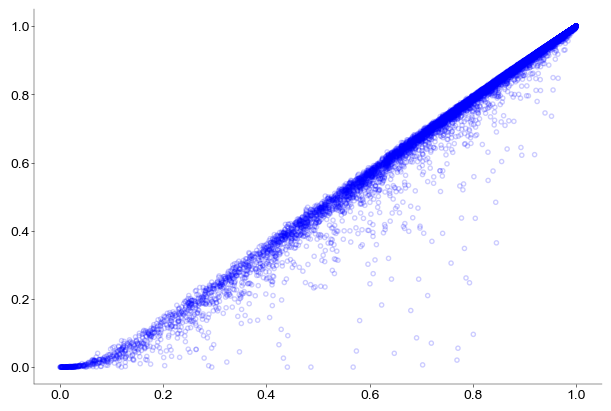

In [29]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(frac_zeros_true, 
           frac_zeros_pred, facecolor='none', edgecolor='b', alpha=0.2)

# ax.set_xscale('log')
# ax.set_yscale('log')

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [31]:
# Compute the variance of the expression counts of each gene
var_expression = counts.std(axis=0) ** 2

Text(0, 0.5, 'Expression variance')

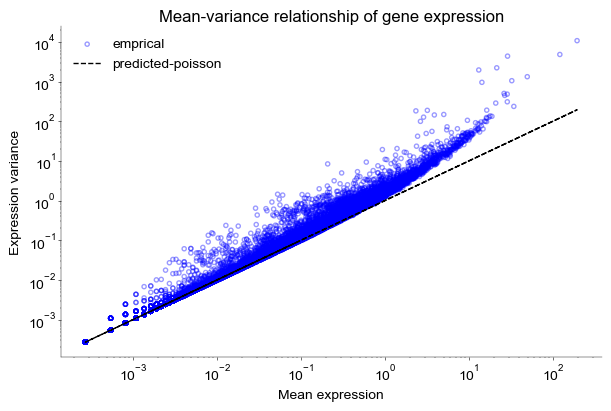

In [35]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------
var_pred = mean_expression.copy()

ax.scatter(mean_expression, var_expression, facecolor='none', edgecolor='b', alpha=0.4, label='emprical')
ax.plot(mean_expression, var_pred, linestyle='--', color='black', label='predicted-poisson')

ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Mean-variance relationship of gene expression")

ax.set_xlabel("Mean expression")
ax.set_ylabel("Expression variance")

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [36]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.
fano = var_expression / mean_expression

Text(0, 0.5, 'Fano-factor')

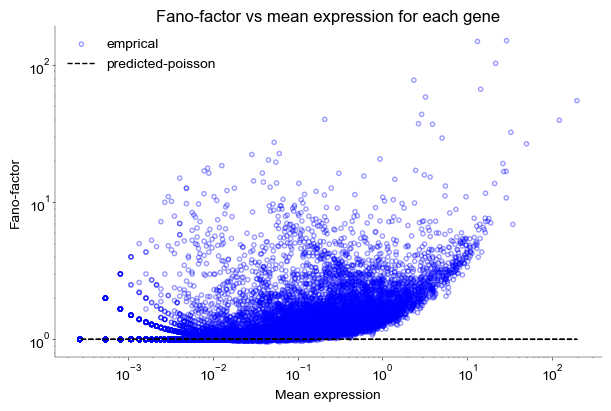

In [37]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------

fano_pred = np.ones(len(mean_expression))

ax.scatter(mean_expression, fano, facecolor='none', edgecolor='b', alpha=0.4, label='emprical')
ax.plot(mean_expression, fano_pred, linestyle='--', color='black', label='predicted-poisson')

ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Fano-factor vs mean expression for each gene")

ax.set_xlabel("Mean expression")
ax.set_ylabel("Fano-factor")

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

Text(0.5, 0, 'Sequencing depth, counts')

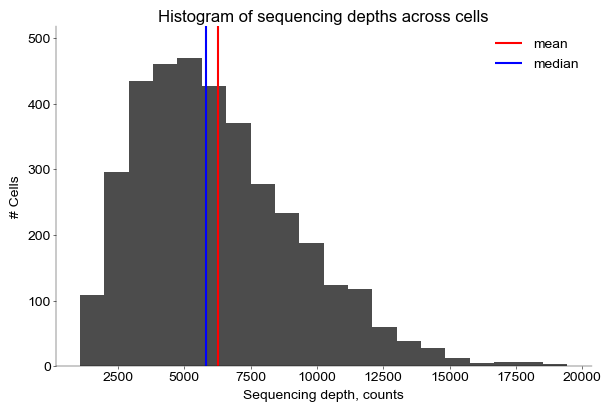

In [46]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

n_bins = 20

depths = counts.sum(axis=1)
ax.hist(depths, bins=n_bins, color='k', alpha=0.7)

ylim = (0, np.max(np.histogram(depths, bins=n_bins)[0]) + 50)
ax.set_ylim(ylim)
ax.vlines(depths.mean(), *ylim, linewidth=1.5, color='red', label='mean')
ax.vlines(np.median(depths), *ylim, linewidth=1.5, color='blue', label='median')

ax.legend()
ax.set_title("Histogram of sequencing depths across cells")
ax.set_ylabel("# Cells")
ax.set_xlabel("Sequencing depth, counts")

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [51]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------

med_depth   = np.median(depths)
norm_counts = counts / depths[:, np.newaxis] * med_depth
fano_norm        = norm_counts.std(axis=0) ** 2 / norm_counts.mean(axis=0)
mean_expression_norm = norm_counts.mean(axis=0)

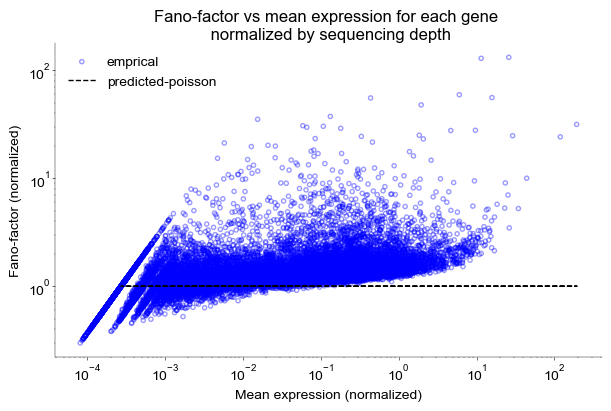

In [54]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

fano_pred = np.ones(len(mean_expression))

ax.scatter(mean_expression_norm, fano_norm, facecolor='none', edgecolor='b', alpha=0.4, label='emprical')
ax.plot(mean_expression, fano_pred, linestyle='--', color='black', label='predicted-poisson')

ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Fano-factor vs mean expression for each gene \n normalized by sequencing depth")

ax.set_xlabel("Mean expression (normalized)")
ax.set_ylabel("Fano-factor (normalized)");


In [68]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# Plot a Poisson prediction as line
# Use the same style of plot as above.

top_genes_idx = (np.argsort(fano_norm))[-10:]
print("Top genes by Fano factor")
for i, idx in enumerate(top_genes_idx):
    print(f"Gene #{10 - i:02d}, Fano = {fano_norm[idx]:.2f}, {genes[idx]}")

Top genes by Fano factor
Gene #10, Fano = 30.59, Armc2
Gene #09, Fano = 31.42, Malat1
Gene #08, Fano = 35.06, Pdzd9
Gene #07, Fano = 37.25, Ptpn23
Gene #06, Fano = 47.65, Pcp4
Gene #05, Fano = 55.22, Cpne2
Gene #04, Fano = 55.65, Cck
Gene #03, Fano = 59.11, Vip
Gene #02, Fano = 128.40, Npy
Gene #01, Fano = 131.14, Sst


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [70]:
fano_norm.shape

(17965,)

In [83]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
# Select all genes with the normalized Fano factor above 3 and remove the rest
keep   = fano_norm > 3
counts = norm_counts[:, keep]
genes  = genes[keep]

In [73]:
%%time
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA

counts_log = np.log2(counts + 1)
counts_sqrt = np.sqrt(counts)

# perform PCA

pca_raw = PCA().fit(counts)
pca_log = PCA().fit(counts_log)
pca_sqrt = PCA().fit(counts_sqrt)

In [80]:
clusterColors.shape

(49, 3)

In [86]:
counts.shape

(3663, 707)

Text(0.5, 0.98, 'Principal components of the dataset')

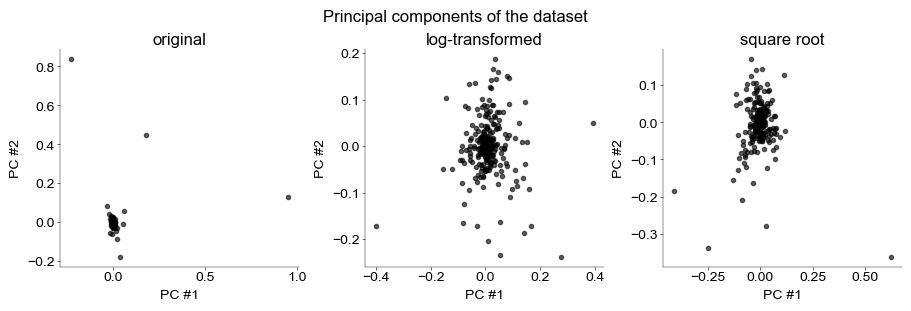

In [89]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

titles = ["original", "log-transformed", "square root"]
for i, pca in enumerate([pca_raw, pca_log, pca_sqrt]):
    ax = axs[i]
    
    ax.set_title(titles[i])
    ax.scatter(pca.components_[0], pca.components_[1], color='black', alpha=0.6)
    ax.set_xlabel("PC #1")
    ax.set_ylabel("PC #2")
    
plt.suptitle("Principal components of the dataset")

In [91]:
%%time
# let's reduce dimensionality of the data using pca.fit_transform!

counts_raw_pca = PCA(n_components=2).fit_transform(counts)
counts_log_pca = PCA(n_components=2).fit_transform(counts_log)
counts_sqrt_pca = PCA(n_components=2).fit_transform(counts_sqrt)

CPU times: total: 422 ms
Wall time: 160 ms


Text(0.5, 0.98, 'PCA dimensionality reduction applied to dataset. True clusters are shown.')

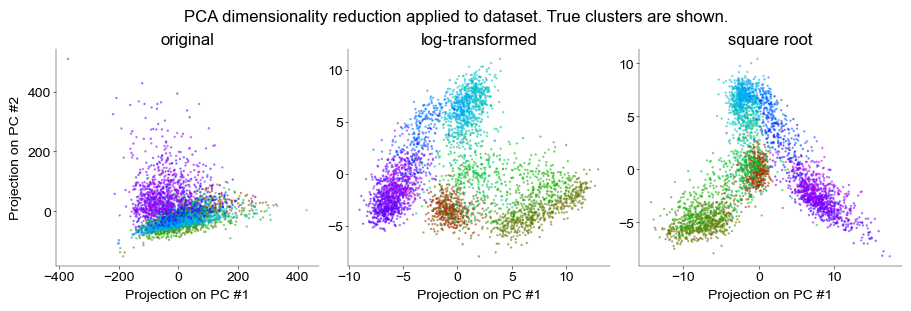

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

titles = ["original", "log-transformed", "square root"]
counts_pca_list = [counts_raw_pca, counts_log_pca, counts_sqrt_pca]

for i in range(3):
    ax = axs[i]
    ax.set_title(titles[i])
    ax.scatter(counts_pca_list[i][:, 0], counts_pca_list[i][:, 1], c=cellColors, s=2, alpha=0.5)
    ax.set_xlabel("Projection on PC #1")
    if i == 0: ax.set_ylabel("Projection on PC #2")
    
plt.suptitle("PCA dimensionality reduction applied to dataset. True clusters are shown.")

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [101]:
%%time
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs

### To PCs or projection of the dataset on PCs?? ###

# Use default settings of openTSNE
# You can also use sklearn if you want

counts_raw_pca = PCA(n_components=50).fit_transform(counts)
counts_log_pca = PCA(n_components=50).fit_transform(counts_log)
counts_sqrt_pca = PCA(n_components=50).fit_transform(counts_sqrt)

tsne = TSNE()

counts_raw_tsne = tsne.fit(counts_raw_pca)
counts_log_tsne = tsne.fit(counts_log_pca)
counts_sqrt_tsne = tsne.fit(counts_sqrt_pca)

CPU times: total: 56.9 s
Wall time: 53.1 s


Text(0.5, 0.98, 'TSNE dimensionality reduction applied to dataset. True clusters are shown.')

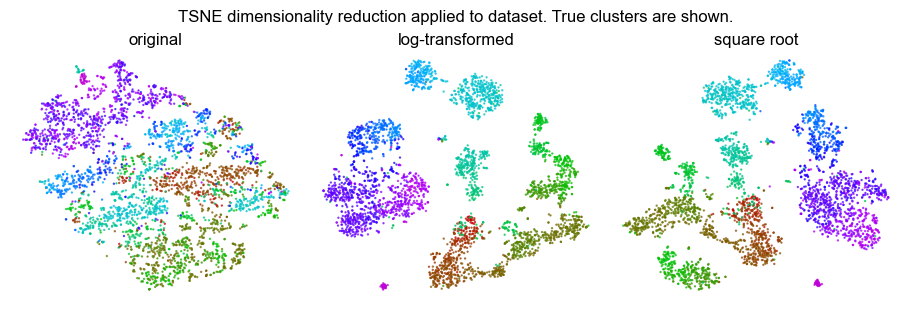

In [119]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

titles = ["original", "log-transformed", "square root"]
counts_tsne_list = [counts_raw_tsne, counts_log_tsne, counts_sqrt_tsne]

for i in range(3):
    ax = axs[i]
    ax.scatter(counts_tsne_list[i][:, 0], counts_tsne_list[i][:, 1], c=cellColors, s=2, alpha=0.7)
    ax.set_title(titles[i])

    ax.axis('off')
plt.suptitle("TSNE dimensionality reduction applied to dataset. True clusters are shown.")

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [120]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [21]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?` 
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
A = ig.
A = NearestNeighbors(15, )
# Transform it into an igraph object
sources, targets = A.nonzero()

In [122]:
la?

Type:        module
String form: <module 'leidenalg' from 'C:\\Users\\aleks\\anaconda3\\envs\\neuro_sp\\lib\\site-packages\\leidenalg\\__init__.py'>
File:        c:\users\aleks\anaconda3\envs\neuro_sp\lib\site-packages\leidenalg\__init__.py
Docstring:  
This package implements the Leiden algorithm in ``C++`` and exposes it to
python.  It relies on ``(python-)igraph`` for it to function. Besides the
relative flexibility of the implementation, it also scales well, and can be run
on graphs of millions of nodes (as long as they can fit in memory). Each method
is represented by a different class, all of whom derive from
:class:`~leidenalg.VertexPartition.MutableVertexPartition`. In addition,
multiplex graphs are supported as layers, which also supports multislice
representations.

Examples
--------

The simplest example just finds a partition using modularity

  >>> G = ig.Graph.Tree(100, 3)
  >>> partition = la.find_partition(G, la.ModularityVertexPartition)

Alternatively, one can access 

In [22]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type

In [ ]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [ ]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

(-67.52920428861165, 68.45317921108641, -61.5705516418754, 72.22259231348454)

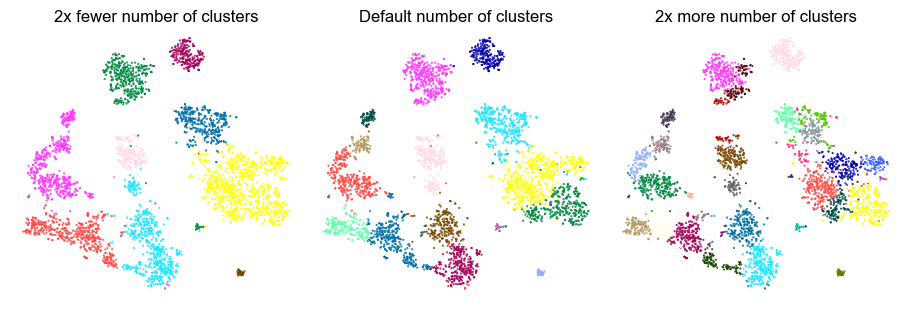

In [26]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot